In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np


torch.manual_seed(0)
import torch.nn as nn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch import Tensor
from torchvision import datasets
import plotly.graph_objects as go


import collections
# import target
# import controler
# import utils

from multiprocessing import Pool
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import attacks
import blackbox

import sys
sys.path.insert(1, '/home/mheuillet/Desktop/attack_detection/partial_monitoring')

import random_algo
import geometry
import geometry_v2
import cpb
import feedexp3_v2
import bpm
import random_algo
import feedexp3_v3
import feedexp3

import TSPM
import eTSPM
import ucbtspm
import ucbTSPM_v2
import cpb_side


import games

# dataloaders, dataset_sizes = utils.task_loader('online')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 
device

device(type='cuda', index=0)

In [26]:


class DataStream:

    def __init__(self, horizon, sample, m, s):
        self.horizon = horizon
        self.sample = sample
        self.m = m
        self.s = s
        self.R = {}
        self.Sa = []

    def random_stream(self, data, blackbox, outcome_distribution ):

        stream = []
        label = []
        outcomes = []
        for i, idx, in enumerate(self.sample) :
            outcome = np.random.choice( [1, 0], p=outcome_distribution)
            X,y =  data[idx]

            X = X.reshape( (1,1,28,28) ).to(device)
            # zero mask
            mask = (self.s != 0)

            # finally perform division
            X[mask] = X[mask] / self.s[mask]

            X -= self.m
            print(X)
            y = torch.Tensor([ y ]).type(torch.LongTensor).to(device)
            if outcome==1:
                delta = attacks.pgd_linf(blackbox, X , y).to(device)
                X = X + delta
            stream.append(  X[0] )
            label.append(y)
            outcomes.append([outcome])

        stream = torch.stack(stream).to('cpu').detach() 
        label = torch.stack(label).to('cpu').detach() 
        status = torch.Tensor(outcomes).to('cpu').detach() 
        
        return  TensorDataset( stream, label, status ) 

    def virtual_plus(self, i, v_i, t, k, exhaust):

        outcome = 0

        if i <= t: # sampling phase
            self.R[i] = v_i
            self.R = { k: v for k, v in sorted(self.R.items(), key=lambda item: item[1]) }
            
        else: # selection phase
            last_value = list( self.R.values() )[-1]
            last_key = list( self.R.keys() )[-1]
            num_left_to_pick = k - len(self.Sa) 
            num_samples_left = self.horizon - i
            if  num_samples_left <= num_left_to_pick and exhaust and num_left_to_pick > 0:
                self.Sa.append(i)
                outcome = 1

            if v_i >= last_value and len(self.Sa) <= k:
                del self.R[ last_key ]
                self.R[i] = v_i
                self.R = {k: v for k, v in sorted(self.R.items(), key=lambda item: item[1])}
                self.Sa.append(i)
                outcome = 1

        return outcome

    def secretary_stream(self, data, blackbox, t, k, exhaust):

        stream = []
        label = []
        outcomes = []

        for i, idx, in enumerate(self.sample) : 

            X, y =  data[idx]
            X = X.reshape( (1,1,28,28) ).to(device)
            y = torch.Tensor([ y ]).type(torch.LongTensor).to(device)

            delta = attacks.pgd_linf(blackbox, X , y).to(device)
            X_prime = X + delta
            v_i = nn.CrossEntropyLoss()( blackbox(X_prime) ,y)

            outcome = self.virtual_plus( i, v_i, t, k, exhaust)

            stream.append(  X[0]  )
            label.append(y )
            outcomes.append([outcome])

        stream = torch.stack(stream).to('cpu').detach().numpy()
        label = torch.stack(label).to('cpu').detach().numpy()
        status = torch.Tensor(outcomes).to('cpu').detach().numpy()
        #
        return  TensorDataset( stream, label, status ) 


# blackbox_model = blackbox.load()
# mnist_val = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor() )
# datastream = DataStream()
# # random_stream = datastream.random_stream( mnist_val, blackbox_model, [0.5,0.5] )
# sec_stream = datastream.secretary_stream( mnist_val, blackbox_model  )

In [27]:
def get_stream(data, blackbox, horizon, outcome_distribution, m, s):
    
    sample = np.random.randint(0, len(data), horizon) #np.random.permutation( range(horizon) )
    datastream = DataStream( horizon, sample, m, s)
    stream = datastream.random_stream(  data, blackbox, list(  outcome_distribution.values() ) )
    # stream = datastream.secretary_stream( data, blackbox, 25, 10, True )
    return stream

def evaluate_parallel(nbCores, n_folds, horizon, alg):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 

    data_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor() )
    X_train = [  d[0]   for d in data_train ]
    X_train = torch.stack(X_train)
    m = X_train.mean(0, keepdim=True).to(device)
    s = X_train.std(0, unbiased=False, keepdim=True).to(device)

    data = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor() )
    blackbox_model = blackbox.load()

    games_list = []
    streams = []
    for jobid in range(n_folds):

        np.random.seed(jobid)

        p = np.random.uniform(0,0.2)
        outcome_distribution =  {'spam':p,'ham':1-p}

        game = games.label_efficient(  )
        game.set_outcome_distribution( outcome_distribution )
        games_list.append(game)

        stream = get_stream( data, blackbox_model, horizon, outcome_distribution, m, s )
        streams.append(stream)

    task = Evaluation(horizon, )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, ), zip(games_list, streams) ) ) 

class Evaluation:

    def __init__(self, horizon, ):

        self.horizon = horizon

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, job,):

        game, stream = job

        action_counter = np.zeros( (game.n_actions, self.horizon) )
        cum_regret = []

        # generate outcomes obliviously
        #datastream = self.get_stream(game, jobid)

        for t, data in enumerate(stream ):
            

            X, label, outcm = data
            X =  X.numpy().flatten() 

            # Environment chooses one outcome
            outcome = int( outcm[0] )


            # policy chooses one action
            action = alg.get_action(t, X)

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, X)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

            cum_regret.append( game.LossMatrix[action,outcome] - min(game.LossMatrix[...,outcome]) )

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        
        return np.cumsum( cum_regret )



In [28]:

n_cores = 1
n_folds = 1
horizon = 100

# data_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor() )
# X_train = [  d[0]   for d in data_train ]
# X_train = torch.stack(X_train)
# m = X_train.mean(0, keepdim=True).to(device)
# s = X_train.std(0, unbiased=False, keepdim=True).to(device)


game =  games.label_efficient(  ) 

data = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor() )
blackbox_model = blackbox.load()

np.random.seed(1)

p = np.random.uniform(0, 0.2)
outcome_distribution =  {'spam':p,'ham':1-p}

game.set_outcome_distribution( outcome_distribution )

# print('optimal action', game.i_star)
alg = cpb_side.CPB_side(  game, horizon,)
task = Evaluation(horizon)
stream = get_stream(data, blackbox_model, horizon, outcome_distribution, m, s)
job = game, stream 
result = task.eval_policy_once(alg, job)

# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00, -8.2353e-06, -3.0719e-05, -1.4118e-05,
           -5.8824e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0458e-06,
           -3.5948e-06, -3.6405e-05, -9.5229e-05, -1.7144e-04, -2.5137e-04,
           -4.7111e-04, -6.3033e-04, -6.8307e-04, -6.9582e-04, -7.4242e-04,
           -6.8294e-04, -7.3307e-04, -6.0255e-04, -3.9261e-04, -2.7935e-04,
           -2.1105e-04, -8.3791e-05, -3.9542e-05, -1.3856e-05,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -4.1830e-06, -2.7451e-06, -2.7255e-05,
           -2.1503e-05, -1.8471e-04, -5.4275e-04, -1.0360e-03,

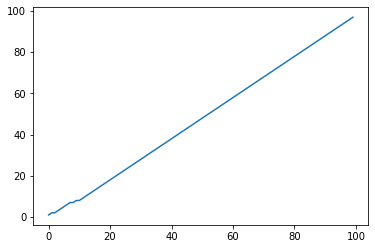

In [29]:
plt.plot(range(horizon), result)

In [25]:
s.shape

torch.Size([1, 1, 28, 28])

In [15]:
n_cores = 16
n_folds = 25
horizon = 500

game = games.label_efficient(  )

algos = [ random_algo.Random(  game, horizon, ), 
           feedexp3.FeedExp3(  game, horizon, ),
           feedexp3_v3.FeedExp3(  game, horizon, ),
           cpb.CPB(  game, horizon,),  
           TSPM.TSPM_alg(  game, horizon,), 
           #eTSPM.eTSPM_alg(  game, horizon, 1),
           ucbTSPM_v2.TSPM_alg(game, horizon)    ] #TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

colors = [ [0,0,0], [29,176,0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], ] # [255,51,255], [255,20,200]  ] #
labels = ['random', 'FeedExp3 (2001)', 'FeedExp3 (2006)',  'CPB' ,  'TSPM' , 'ucbTSPM (Auer)'  ]  # 'CPB',  'eTSPM (Auer)',

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg)
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 100] )
fig.show()

n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
nbCores: 16 nbFolds: 25 Horizon: 500
(25, 500)
